# A Jupyter Notebook to Perform Pricing Using the Bates Formula
This notebook demonstrates the implementation of the Bates formula for pricing Bonus Certificates. It includes steps for importing libraries, defining the formula, setting parameters, simulating asset price paths, calculating option prices, and visualizing results.

## Import Required Libraries
Import necessary libraries such as NumPy, SciPy, and Matplotlib for numerical computations and visualizations.

In [1]:
import sys
import os
import datetime
sys.path.append(os.path.abspath('..'))  # Adds the parent directory to the Python path

In [2]:
# data
S0 = 81.25
B = 85
L = 65
H = 55
q = 0.02
start_date = valuation_date = datetime.datetime(2025, 4, 25)
maturity_date = datetime.datetime(2026, 3, 20)
T = 328/365 # 08/04/25 - 16/06/26
T = (maturity_date - valuation_date).days / 365.0

In [3]:
# Import Required Libraries
from src.payout.payout import calculate_bonus_certificate_payout, plot_payout

In [4]:
plot_payout(B, H, S0)

## Calculate interest rate
Obtain interest rate from forward prices of the vanilla market prices

In [5]:
from src.interest_rates.calculate_interest_rates import calculate_interest_rate_from_parity, plot_interest_rates
import pandas as pd

In [6]:
# Load the CSV file into a pandas DataFrame
file_path = "../data/marketDataClose25-04/060625.csv"  # Adjust the path if necessary
df = pd.read_csv(file_path)
df['Spot'] = S0
df = df[['Bid_Call', 'Ask_Call', 'Bid_Put', 'Ask_Put', 'Spot', 'Strike', 'IV_Put', 'IV_Call']]

# Display the first few rows of the DataFrame
print(df.head())

   Bid_Call  Ask_Call  Bid_Put  Ask_Put   Spot  Strike  IV_Put  IV_Call
0      34.3      38.3      0.0     1.40  81.25    45.0   0.662    0.662
1      29.4      33.4      0.0     1.40  81.25    50.0   0.662    0.662
2      24.4      28.4      0.0     1.55  81.25    55.0   0.659    0.659
3      19.5      23.5      0.0     2.25  81.25    60.0   0.646    0.646
4      14.6      18.6      0.0     1.55  81.25    65.0   0.599    0.599


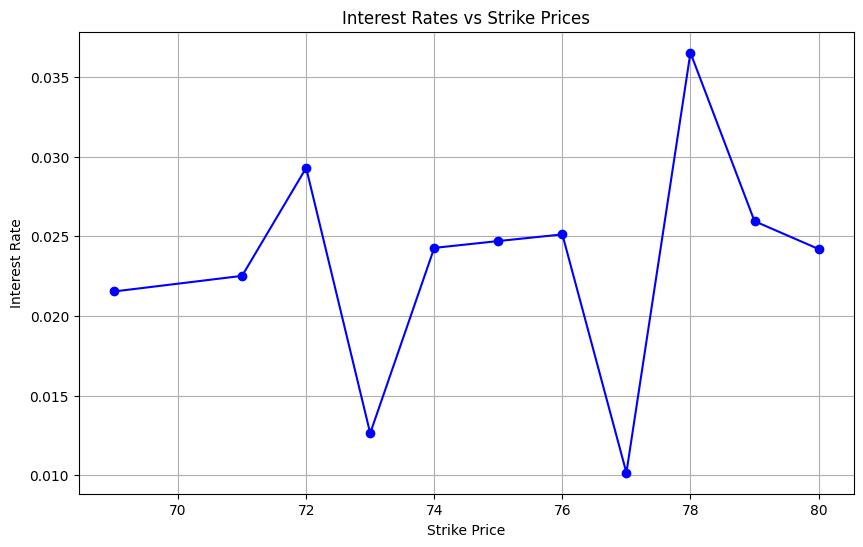

0.023357858029929766


In [7]:
# Calculate interest rates from parity
interest_rates = calculate_interest_rate_from_parity(df, q, T)
# print (interest_rates.head())

# Display the calculated interest rates
plot_interest_rates(interest_rates)

r = interest_rates['InterestRate'].mean()
print(r)
r = 0.04

In [8]:
# Store the mean interest rate in a variable
mean_interest_rate = interest_rates['InterestRate'].mean()
print(f'Mean Interest Rate: {mean_interest_rate}')

Mean Interest Rate: 0.023357858029929766


## Calculate volatility skew
Plot IV versus strike, note call are underpriced due to dividends and market crash after "liberation" day

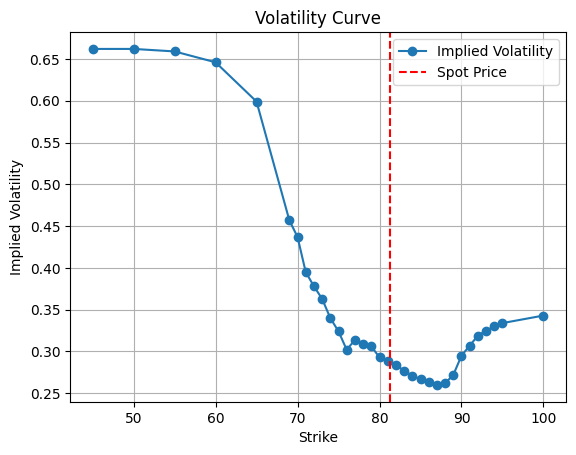

In [9]:
import matplotlib.pyplot as plt

# Add a new column for implied volatility based on the condition
df['ImpliedVolatility'] = df.apply(
    lambda row: row['IV_Put'] if row['Strike'] < S0 else row['IV_Call'], axis=1
)

# Plot the implied volatility curve
plt.plot(df['Strike'], df['ImpliedVolatility'], 'o-', label='Implied Volatility')
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.title("Volatility Curve")
plt.axvline(x=S0, color='red', linestyle='--', label='Spot Price')
plt.grid(True)
plt.legend()
plt.show()

## Calibrate Bates Model
Use the Bates model to calibrate on market prices and minimize the sum of squared errors.

In [10]:
from src.bates_formula.calibration import calibrate_bates_model

data_folder = '../data/marketDataClose25-04'
all_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
data_frames = []

for file in all_files:
    file_path = os.path.join(data_folder, file)
    df = pd.read_csv(file_path)
    df['Source'] = file  # Add a column to identify the source file
    data_frames.append(df)

combined_data = pd.concat(data_frames, ignore_index=True)

# Add a new column 'Mid_Price' based on the condition
combined_data['Mid_Price'] = combined_data.apply(
    lambda row: (row['Bid_Call'] + row['Ask_Call']) / 2 if row['Strike'] > S0 else (row['Bid_Put'] + row['Ask_Put']) / 2,
    axis=1
)

# Display the first few rows to verify the new column
print(combined_data[['Strike', 'Bid_Call', 'Ask_Call', 'Bid_Put', 'Ask_Put', 'Mid_Price']].head())
# Extract market prices and strikes
market_prices = combined_data['Mid_Price']  # Mid prices for calls
strikes = combined_data['Strike']

# Use the mean interest rate in Bates model calibration
calibrated_params = calibrate_bates_model(market_prices, strikes, S0, T, mean_interest_rate, q)
print("Calibrated Bates Model Parameters:", calibrated_params)

   Strike  Bid_Call  Ask_Call  Bid_Put  Ask_Put  Mid_Price
0    30.0      49.4      54.0     0.10     2.25      1.175
1    35.0      44.5      48.4     0.00     1.45      0.725
2    37.5      42.1      46.0     0.00     1.50      0.750
3    40.0      39.7      43.6     0.10     0.50      0.300
4    42.5      37.2      41.4     0.15     1.20      0.675
Calibrated Bates Model Parameters: {'V0': np.float64(0.01), 'kappa': np.float64(1.9480657902585703), 'eta': np.float64(0.01), 'theta': np.float64(0.2361370045671596), 'rho': np.float64(0.99), 'jump_intensity': np.float64(1.0), 'jump_mean': np.float64(-0.5), 'jump_stddev': np.float64(0.01)}


## Plot Market Prices
Visualize the calibrated Bates model prices against the actual market prices.

   BS_Call  Last_Call  Bid_Call  Ask_Call  Change_Call  Delta_Call  IV_Call  \
0       BS      42.66     49.40     54.00         0.00       0.995    0.490   
1       BS       0.00     44.50     48.40         0.00       0.991    0.485   
2       BS       0.00     42.10     46.00         0.00       0.986    0.478   
3       BS      33.60     39.70     43.60         0.00       0.971    0.457   
4       BS       0.00     37.20     41.40         0.00       0.964    0.444   
5       BS      28.13     35.00     39.00         0.00       0.955    0.454   
6       BS       0.00     32.60     36.70         0.00       0.949    0.429   
7       BS      32.75     30.30     34.20         0.00       0.934    0.407   
8       BS      28.26     28.10     31.60         0.00       0.918    0.382   
9       BS      20.10     26.30     29.30         0.00       0.902    0.363   
10      BS      25.78     24.50     26.30         0.00       0.884    0.352   
11      BS      28.90     22.40     23.90         0.

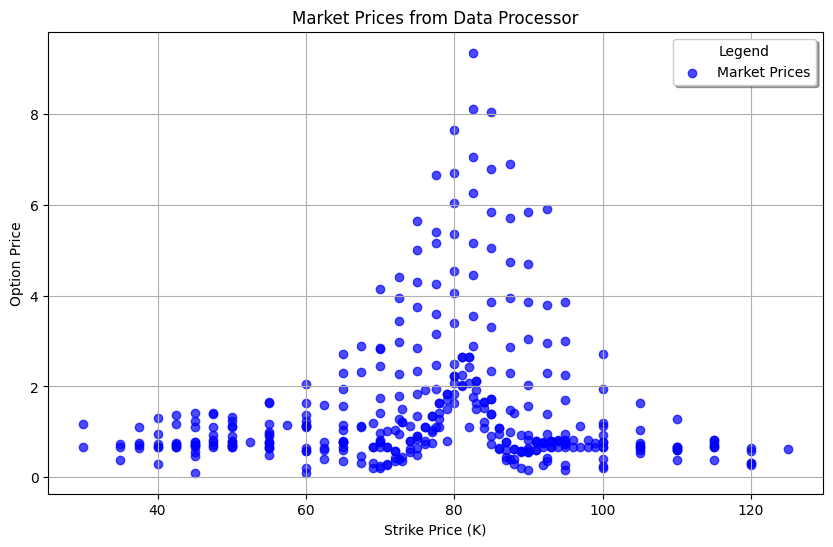

In [11]:
# Use MarketDataProcessor to load and process data
from src.data_processing.market_data_processor import MarketDataProcessor

# Initialize the MarketDataProcessor
data_folder = '../data/marketDataClose25-04'
S0 = 81.25
processor = MarketDataProcessor(data_folder, S0)
processor.load_and_process_data()

# Access the combined data
combined_data = processor.combined_data
print(combined_data.head(50))

# Plot market prices
plt.figure(figsize=(10, 6))
plt.scatter(combined_data['Strike'], combined_data['Mid_Price'], label='Market Prices', color='blue', marker='o', alpha=0.7)

# Add labels, title, and legend
plt.xlabel('Strike Price (K)')
plt.ylabel('Option Price')
plt.title('Market Prices from Data Processor')
plt.legend(title='Legend', loc='best', fancybox=True, shadow=True)
plt.grid(True)

# Show the plot
plt.show()

## Calibrate Bates Model Globally
Use the BatesModelGlobalCalibrator class to find the best parameters for all maturities combined.

In [12]:
import numpy as np

global_params = {
    'V0': np.float64(0.03314133662402323),
    'kappa': np.float64(2.0),
    'eta': np.float64(0.06797967406717075),
    'theta': np.float64(0.14987718209558357),
    'rho': np.float64(-0.99),
    'jump_intensity': np.float64(0.01),
    'jump_mean': np.float64(0.01),
    'jump_stddev': np.float64(0.01)
}

In [13]:
print(global_params)

{'V0': np.float64(0.03314133662402323), 'kappa': np.float64(2.0), 'eta': np.float64(0.06797967406717075), 'theta': np.float64(0.14987718209558357), 'rho': np.float64(-0.99), 'jump_intensity': np.float64(0.01), 'jump_mean': np.float64(0.01), 'jump_stddev': np.float64(0.01)}


In [14]:
from src.bates_formula.calibration_global import BatesModelGlobalCalibrator
from src.bates_formula.bates_model import BatesModel



# Perform global calibration for each maturity
calibrated_results = []

global_calibrator = BatesModelGlobalCalibrator(data_folder, S0, r, q, start_date, combined_data)

# Perform global calibration across all maturities and strikes
#global_calibrator.calibrate_global_model(combined_data)

# Retrieve calibrated parameters
calibrated_params = global_calibrator.get_global_calibrated_params()

print("Global Calibrated Parameters:")
print(calibrated_params)


Global Calibrated Parameters:
{}


In [15]:
# Update the calibrated_params dictionary with the provided values
calibrated_params.update({
    'V0': 0.030353015389345157,
    'kappa': 2.0,
    'eta': 0.06888174025470413,
    'theta': 0.13008042992772578,
    'rho': -0.99,
    'jump_intensity': 0.01,
    'jump_mean': 0.01,
    'jump_stddev': 0.01
})

In [16]:
calibrated_model = BatesModel(
    S0=S0,
    r=r,
    q=q,
    T=T,
    strikes=strikes,
    V0=calibrated_params['V0'],
    kappa=calibrated_params['kappa'],
    eta=calibrated_params['eta'],
    theta=calibrated_params['theta'],
    rho=calibrated_params['rho'],
    jump_intensity=calibrated_params['jump_intensity'],
    jump_mean=calibrated_params['jump_mean'],
    jump_stddev=calibrated_params['jump_stddev']
)

priced_data = calibrated_model.price_options_for_all_maturities(combined_data, start_date)

print(priced_data.shape,combined_data.shape)  # Returns a tuple (rows, columns)


otm_calls:  (167, 21)
otm_puts:  (213, 21)


(380, 23) (380, 21)


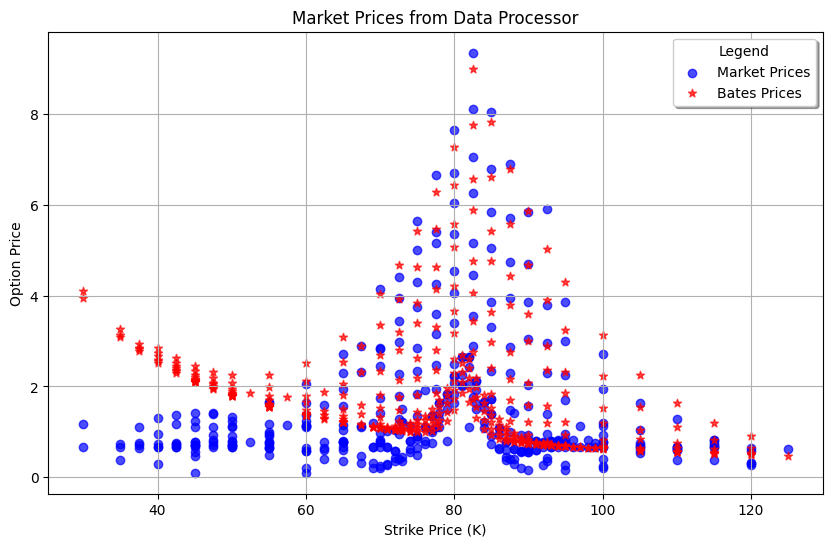

In [17]:
# Plot market prices
plt.figure(figsize=(10, 6))
plt.scatter(combined_data['Strike'], combined_data['Mid_Price'], label='Market Prices', color='blue', marker='o', alpha=0.7)
plt.scatter(priced_data['Strike'], priced_data['Bates_Price'], label='Bates Prices', color='red', marker='*', alpha=0.7)
# Add labels, title, and legend
plt.xlabel('Strike Price (K)')
plt.ylabel('Option Price')
plt.title('Market Prices from Data Processor')
plt.legend(title='Legend', loc='best', fancybox=True, shadow=True)
plt.grid(True)

# Show the plot
plt.show()

OTM Call Prices for Maturity 01/01/2026: [6.57644121 5.42385653 4.43208453 3.59341628 2.89683679 2.32880351
 1.51690392 1.03230858 0.76124484 0.6156788  0.53655795]
OTM Put Prices for Maturity 01/01/2026: [4.10582986 3.25967758 2.94035427 2.67098352 2.44238435 2.24842708
 2.08561902 1.9529656  1.85199636 1.78685957 1.76439562 1.79410764
 1.88796253 2.05997946 2.3255942  2.70082304 3.20128409 3.84116127
 4.63221135 5.58291635]


ValueError: x and y must be the same size

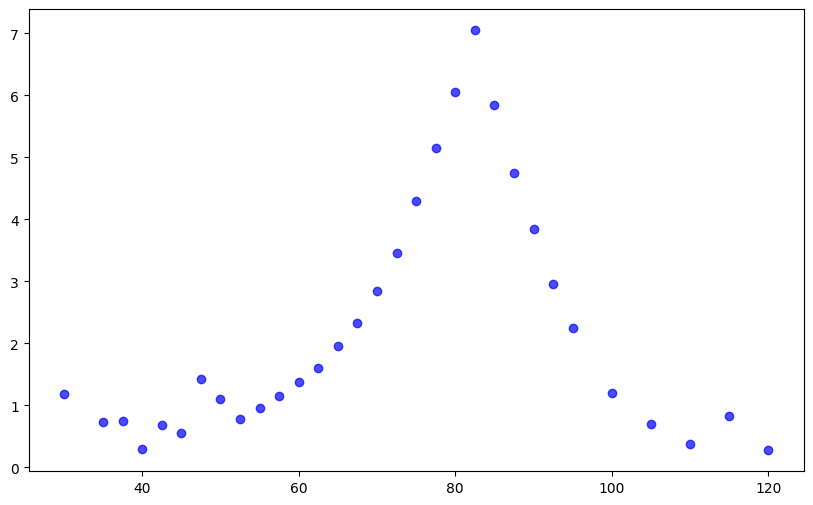

In [ ]:
# Loop over each maturity separately
for maturity in combined_data['Maturity'].unique():
    # Filter data for this maturity
    df_maturity = combined_data[combined_data['Maturity'] == maturity]
    
    # Extract strikes and market mid-prices
    strikes = df_maturity['Strike'].values
    market_prices = df_maturity['Mid_Price'].values

    # Compute time to maturity T in years
    valuation_date = datetime.datetime(2025, 4, 25)
    maturity_date = datetime.datetime.strptime(maturity, "%m/%d/%Y")
    T = (maturity_date - valuation_date).days / 365

    # Initialize Bates model with calibrated parameters
    bates_model = BatesModel(
        S0, r, q, 
        calibrated_params['V0'], calibrated_params['kappa'], calibrated_params['eta'],
        calibrated_params['theta'], calibrated_params['rho'], 
        T,  # pass correct time to maturity
        strikes=strikes,
        jump_intensity=calibrated_params['jump_intensity'],
        jump_mean=calibrated_params['jump_mean'],
        jump_stddev=calibrated_params['jump_stddev']
    )

    # Separate strikes into OTM calls and puts
    otm_calls = strikes[strikes > S0]
    otm_puts = strikes[strikes < S0]

    # Calculate prices for OTM calls
    call_prices = []
    if len(otm_calls) > 0:
        bates_model.strikes = otm_calls
        call_prices = bates_model.price_options()

    # Calculate prices for OTM puts
    put_prices = []
    if len(otm_puts) > 0:
        bates_model.strikes = otm_puts
        put_prices = bates_model.price_put_options()

    # Combine OTM call and put prices into a single array for plotting
    otm_prices = [None] * len(strikes)
    for i, strike in enumerate(strikes):
        if strike in otm_calls:
            otm_prices[i] = call_prices[list(otm_calls).index(strike)]
        elif strike in otm_puts:
            otm_prices[i] = put_prices[list(otm_puts).index(strike)]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(strikes, market_prices, label='Market Prices', color='blue', marker='o', alpha=0.7)
    plt.scatter(strikes, otm_prices, label='Bates Model OTM Prices', color='red', marker='*', alpha=0.7)

    plt.xlabel('Strike Price (K)')
    plt.ylabel('Option Price')
    plt.title(f'Market vs Bates Model OTM Prices for Maturity {maturity}')
    plt.legend(title='Legend', loc='best', fancybox=True, shadow=True)
    plt.grid(True)
    plt.show()